In [1]:
# matplotlib 한글 깨짐 방지
import platform
import matplotlib

if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    matplotlib.rc('font', family='AppleGothic')
else: # Linux
    matplotlib.rc('font', family='NanumGothic')
    
#plt.rcParams['axes.unicode_minus']=False # 마이너스 기호 깨짐 방지

Feature importances: [0. 1.]


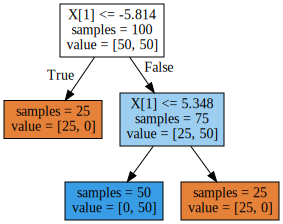

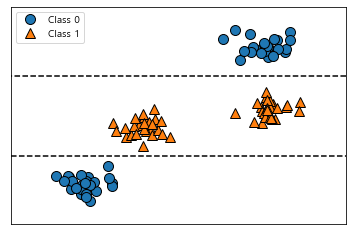

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn

# 경향성을 볼 때는 linear를 쓰고, 분류를 할 때는 tree를 쓴다.
mglearn.plots.plot_tree_not_monotone()

In [3]:
ram_price = pd.read_csv('../datasets/ram_price.csv')
ram_price

,Unnamed: 0,date,price
0,0,1957.00,4.110418e+08
1,1,1959.00,6.794772e+07
2,2,1960.00,5.242880e+06
3,3,1965.00,2.642412e+06
4,4,1970.00,7.340030e+05
...,...,...,...
328,328,2015.58,4.500000e-03
329,329,2015.67,4.300000e-03
330,330,2015.75,4.200000e-03
331,331,2015.83,3.800000e-03


Text(0, 0.5, 'price ($/Mbyte)')

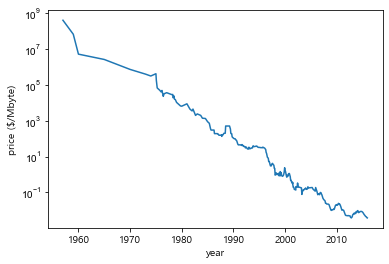

In [4]:
plt.yticks(fontname='Arial')
plt.semilogy(ram_price.date, ram_price.price)
plt.xlabel('year')
plt.ylabel("price ($/Mbyte)")

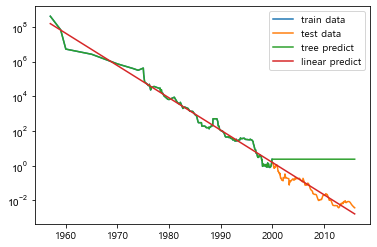

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
data_train = ram_price[ram_price.date < 2000]
data_test = ram_price[ram_price.date >= 2000]
#date는 원래 1차원 데이터인데 ML에서는 2차원 데이터만 사용하므로 데이터를 2차원으로 만들어준다.
x_train = data_train.date[:, np.newaxis] # np.newaxis를 사용하면 2차원 데이터로 만들어준다.
# 매우 큰 데이터는 log를 씌워서 scaling을 한 후 작업을 한다.
y_train = np.log(data_train.price)
tree = DecisionTreeRegressor().fit(x_train, y_train)
linear_reg = LinearRegression().fit(x_train, y_train)
x_all = ram_price.date[:, np.newaxis]
pred_tree = tree.predict(x_all)
pred_lr = linear_reg.predict(x_all)
# 작업이 끝나면 exp를 해준다(log를 했기 때문에)
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

plt.yticks(fontname='Arial')
plt.semilogy(data_train.date, data_train.price, label='train data')
plt.semilogy(data_test.date, data_test.price, label='test data')
plt.semilogy(ram_price.date, price_tree, label='tree predict')
plt.semilogy(ram_price.date, price_lr, label='linear predict')
plt.legend()
plt.show()

### tree를 랜덤하게 만들어서 ensemble한게 random forest다.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
# noise를 적용해서 생성한 데이터를 scatter한다.
x, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

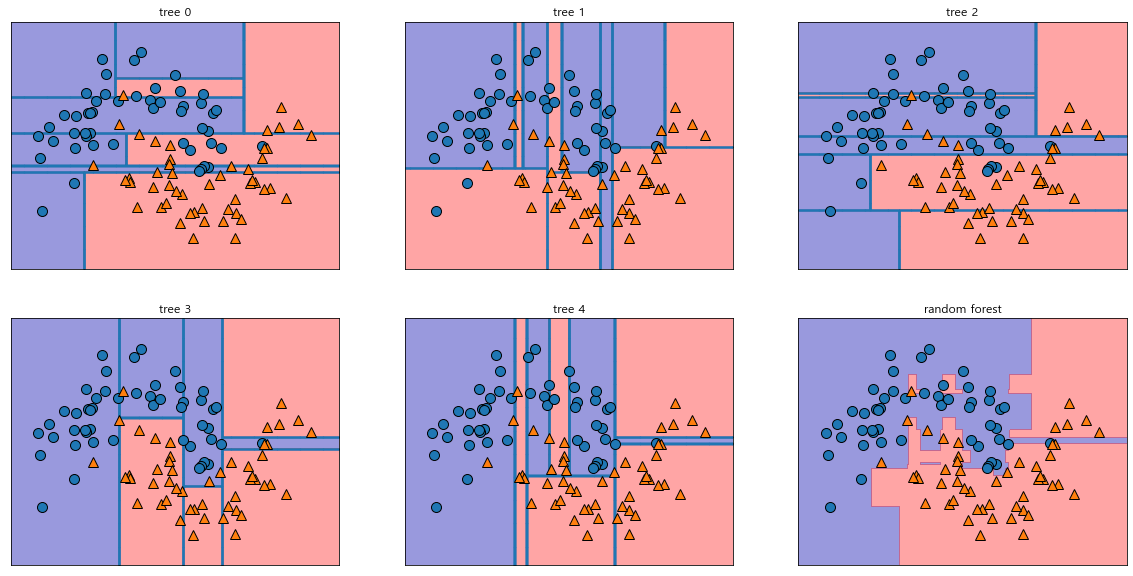

In [7]:
# 성능이 낮은 트리로 성능이 좋은 classifier를 만드는 방법
forest = RandomForestClassifier(n_estimators=5) # n_estimators : tree 개수
forest.fit(X_train, y_train)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)): # axes.ravel()은 2차원인 그림을 1차원으로 만들어준다.
    ax.set_title("tree {}".format(i))
    mglearn.plots.plot_tree_partition(x, y, tree, ax=ax)
mglearn.plots.plot_2d_separator(forest, x, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("random forest")
mglearn.discrete_scatter(x[:,0], x[:,1], y) # parameter order : x axis, y axis, correct answer
plt.show()    
# 다수결로 선택해서 forest를 만들어 분류의 정확도를 높인다.
# tree 0 ~ 4번을 종합해서 다수결로 인해 random forest가 만들어짐.

In [8]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
print("train accuracy: {:.3f}".format(forest.score(X_train, y_train)))
print("test accuracy: {:.3f}".format(forest.score(X_test, y_test)))
# train accuracy: 1.000 : overfitting
# test accuracy: 0.972

train accuracy: 1.000
test accuracy: 0.972


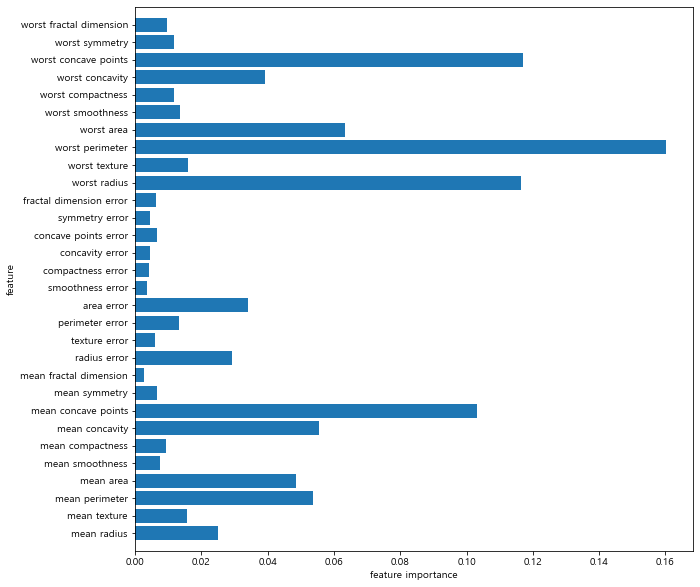

In [9]:
plt.figure(figsize=(10,10))
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1] # shape에서 shape[0]은 row의 수, shape[1]은 col의 수(feature의 수)
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(forest)

In [10]:
# random forest와 달리 GBT는 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
# 강력한 사전가지치기를 사용하고, 각각의 트리는 데이터의 일부에 대해서만 예측을 잘 수행할 수 있어서
# 트리가 많이 추가될수록 성능이 좋아진다.
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
print("train accuracy: {:.3f}".format(gbrt.score(X_train, y_train)))
print("test accuracy: {:.3f}".format(gbrt.score(X_test, y_test)))

train accuracy: 1.000
test accuracy: 0.965


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1) # max_depth를 사용한 hyperparameter tuning
gbrt.fit(X_train, y_train)
print("train accuracy: {:.3f}".format(gbrt.score(X_train, y_train)))
print("test accuracy: {:.3f}".format(gbrt.score(X_test, y_test)))


train accuracy: 0.991
test accuracy: 0.972


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
# learning_rate : 이전 트리의 오차를 얼마나 강하게 보정할 것인지 결정
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01) # learning_rate를 사용한 hyperparameter tuning
gbrt.fit(X_train, y_train)
print("train accuracy: {:.3f}".format(gbrt.score(X_train, y_train)))
print("test accuracy: {:.3f}".format(gbrt.score(X_test, y_test)))


train accuracy: 0.988
test accuracy: 0.965


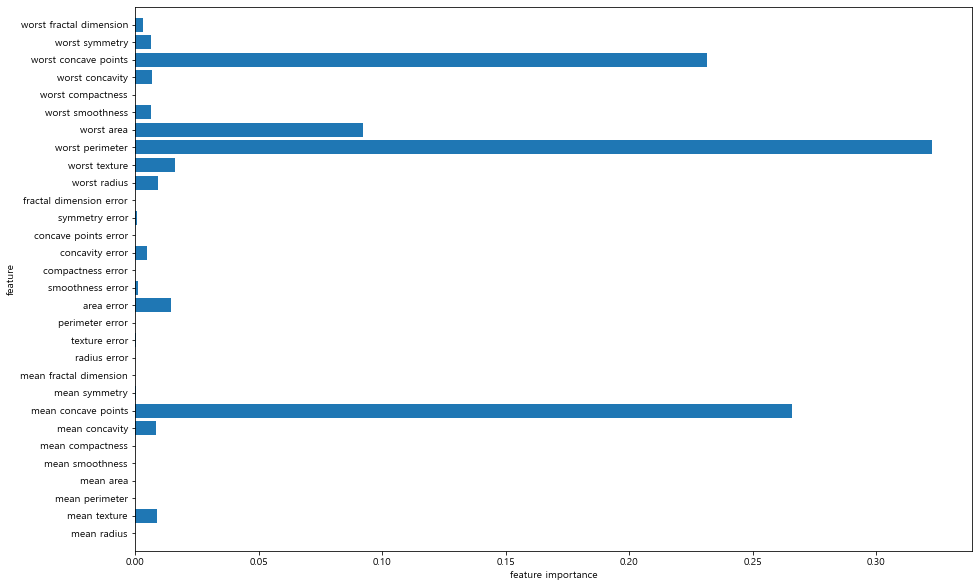

In [13]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1) # max_depth를 사용한 hyperparameter tuning
gbrt.fit(X_train, y_train)

plt.figure(figsize=(15,10))
plot_feature_importances_cancer(gbrt)

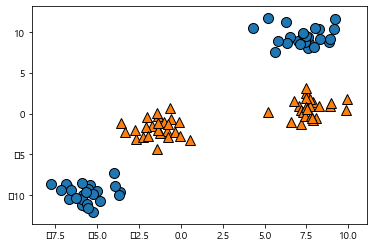

In [14]:
# SVM Kernel trick : 나눌 수 없는 2차원 데이터를 3차원으로 변환한 다음 평면으로 나누고 다시 2차원으로 변환하는 법
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)

y = y % 2
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.show()


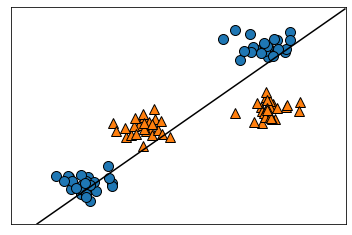

In [15]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:,0], X[:,1], y)

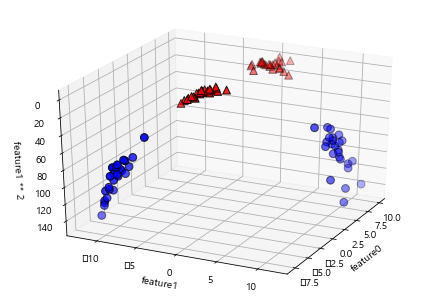

In [16]:
X_new = np.hstack([X, X[:,1:] ** 2])
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
          cmap=mglearn.cm2, s=60, edgecolors='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker="^",
          cmap=mglearn.cm2, s=60, edgecolors='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")
plt.show()

In [17]:
np.linspace(1, 10, 20)

array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ])

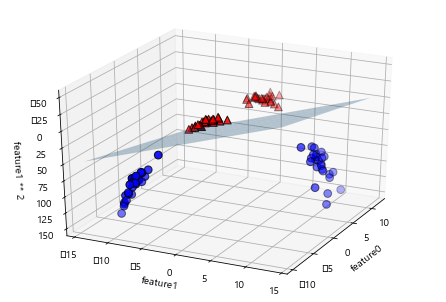

In [18]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:,0].min() - 2, X_new[:,0].max() + 2, 50)
yy = np.linspace(X_new[:,1].min() - 2, X_new[:,1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
          cmap=mglearn.cm2, s=60, edgecolors='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker="^",
          cmap=mglearn.cm2, s=60, edgecolors='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")
plt.show()

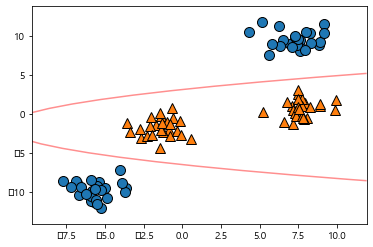

In [19]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function( np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()] )
plt.contour(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
           cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:,0], X[:,1], y)
plt.show()

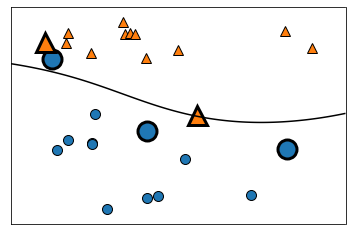

In [23]:
# Cost : 클수록 규제를 풀어주고, 작을수록 규제가 강함. Gamma : 작을수록 직선, 클수록 곡선
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X,y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:,0], X[:,1], y)
sv = svm.support_vectors_
sv_labels = svm.dual_coef_.ravel() > 0
#print(sv_labels)
mglearn.discrete_scatter(sv[:,0], sv[:,1], sv_labels, s=19, markeredgewidth=3) # support vector 시각화

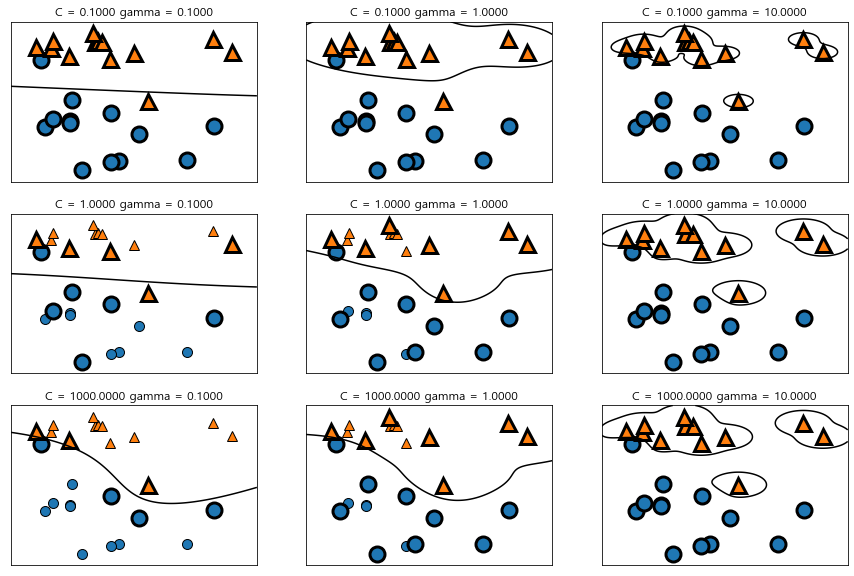

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1,2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
cancer.data, cancer.target, random_state=0)
svc = SVC()
svc.fit(X_train, y_train)
print("train acc {:.2f}".format(svc.score(X_train, y_train)))
print("test acc {:.2f}".format(svc.score(X_test, y_test)))


train acc 0.90
test acc 0.94


In [27]:
min_on_training = X_train.min(axis=0)
range_on_training = (X_train - min_on_training).max(axis=0)
X_train_scaled = (X_train - min_on_training) / range_on_training
# 우리가 만든 공식이 맞는지 체크
print("특성별 최소값\n", X_train_scaled.min(axis=0))
print("특성별 최대값\n", X_train_scaled.max(axis=0))

특성별 최소값
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
특성별 최대값
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


## 데이터의 분산이 너무 크면 학습이 잘 안된다. 그래서 데이터의 분산 모양 그대로 0과 1사이에 모양 그대로 스케일링하면 학습이 잘된다. 그 방법이 MinMaxScaling이다. 
## standard scaler는 avg과 std를 사용해서 scaling한다.   
## 보통 MinMax를 가장 많이 사용한다.

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled2 = scaler.transform(X_train)
X_test_scaled2 = scaler.transform(X_test)
svc = SVC()
svc.fit(X_train_scaled2, y_train)
print("train acc {:.2f}".format(svc.score(X_train_scaled2, y_train)))
print("test acc {:.2f}".format(svc.score(X_test_scaled2, y_test)))
# train acc 0.98
# test acc 0.97

train acc 0.98
test acc 0.97


In [29]:
# no scaling
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
svm = SVC(C=100)
svm.fit(X_train, y_train)
print("test acc: {:.2f}".format(svm.score(X_test, y_test)))

test acc: 0.94


In [33]:
# MinMaxScaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train) # 데이터의 분포와 모양을 학습한다.
#scaler.fit(X_test)
X_train_scaled = scaler.fit_transform(X_train) # 훈련된 정보를 통해 데이터를 스케일링한다.
X_test_scaled = scaler.transform(X_test)
svm = SVC()
svm.fit(X_train_scaled, y_train)
print("test acc : {:.2f}".format(svm.score(X_test_scaled, y_test)))

test acc : 0.97


In [34]:
# 표준이 0이고, std가 1인 scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC()
svm.fit(X_train_scaled, y_train)
print("test acc: {:.2f}".format(svm.score(X_test_scaled, y_test)))

test acc: 0.97
